## Other maturities

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 

from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import minimize
import scipy.integrate as integrate
from scipy import special
from scipy.special import erf
from scipy import optimize
from datetime import date
from datetime import datetime

In [2]:
# Preprocessing
amd_quotes = pd.read_csv('amd_quotedata.csv', parse_dates=['Expiration Date'], index_col=['Expiration Date'])
amd_calls = amd_quotes.iloc[:,0:11] # Remove puts
#amd_calls = amd_calls1.drop('2023-04-06', inplace=True) # Remove date before start date

S0 = 92.3
t0 = date(2023, 4, 8)
amd_calls['Strike/Spot'] = amd_calls['Strike']/S0
amd_calls['Mid'] = (amd_calls['Bid']+amd_calls['Ask'])/2
amd_calls

,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,Open Interest,Strike,Strike/Spot,Mid
Expiration Date,,,,,,,,,,,,,
2023-04-06,AMD230406C00083000,9.50,0.000,9.35,9.55,126,0.0000,0.9984,0.0015,144,83.0,0.899242,9.450
2023-04-06,AMD230406C00084000,8.70,0.275,8.35,8.55,35,0.0000,0.9982,0.0019,110,84.0,0.910076,8.450
2023-04-06,AMD230406C00085000,7.55,0.150,7.35,7.55,180,0.0000,0.9979,0.0024,907,85.0,0.920910,7.450
2023-04-06,AMD230406C00086000,6.63,0.205,6.35,6.55,60,0.0000,0.9976,0.0031,296,86.0,0.931744,6.450
2023-04-06,AMD230406C00087000,5.61,0.110,5.35,5.60,320,0.0000,0.9972,0.0042,308,87.0,0.942579,5.475
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-19,AMD251219C00120000,21.43,-0.220,20.95,22.30,23,0.4378,0.5719,0.0060,70,120.0,1.300108,21.625
2025-12-19,AMD251219C00125000,19.20,-1.000,19.85,20.80,5,0.4371,0.5475,0.0061,27,125.0,1.354280,20.325
2025-12-19,AMD251219C00130000,17.55,-1.225,18.50,19.45,10,0.4342,0.5238,0.0061,33,130.0,1.408451,18.975


In [3]:
def I1(alpha,sigma,s1,K1,K2): 
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return 1/2*np.exp((alpha*sigma)**2/2 + alpha*s1) * (special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2)) )
    
def I2(alpha,sigma,s1,K1,K2):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return sigma*np.exp(alpha*s1) * ( 2*(np.exp(A*alpha*sigma-A*A/2) - np.exp(B*alpha*sigma-B*B/2)) + np.sqrt(2*np.pi)*alpha*sigma*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2))) )
    
def I3(alpha,sigma,s1,K1,K2,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return np.exp(alpha*s1) *  (2*sigma*(np.exp(A*alpha*sigma-A**2/2) - np.exp(B*alpha*sigma-B**2/2))  +   np.sqrt(2*np.pi)*np.exp(alpha*alpha*sigma*sigma/2)*(alpha*sigma**2-Q+s1) * (erf((B-alpha*sigma)/np.sqrt(2)) - erf((A-alpha*sigma)/np.sqrt(2))) )

def I4(alpha,sigma,s1,K1,K2,K,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma  
    return 2*sigma* (np.exp(alpha*A*sigma-A*A/2)*(sigma*(alpha*sigma+A) - K - Q + 2*s1) + np.exp(-1/2*B*(B-2*alpha*sigma))*(-sigma*(alpha*sigma+B) + K + Q -2*s1))  +  np.sqrt(2*np.pi)*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/(np.sqrt(2))) - special.erf((A-alpha*sigma)/(np.sqrt(2))) ) * (sigma**2 - (-alpha*sigma**2+K-s1)*(alpha*sigma**2-Q+s1))

In [4]:
def sigma_objective_(p,C,delta_t,X1,P_disc_X1):
    '''
    C: Pandas dataframe containing all info of that volatility slice (fixed maturity)
    '''
    mid = np.array(C['Mid'])
    K = np.array(C['Strike'])
    sigma0, beta = p[0], p[1]
    sqrtt = math.sqrt(delta_t)
    sigma = lambda s: sigma0*s**beta
    tot = 0
    
    for i in range(K.size): 
        k = K[i]
        help_v = lambda s: (k-s)/(np.sqrt(2)*sqrtt*sigma(s))
        B_vec = lambda s: 0.5*(s-k)*erf(help_v(s)) + sigma(s)*sqrtt/np.sqrt(2*math.pi)*np.exp(-help_v(s)**2)
        B_vec_ = np.vectorize(B_vec)
        expectation_k = np.sum(B_vec_(X1)*P_disc_X1)
        tot += (expectation_k - mid[i])**2 #TODO: compare these two, to check for good fit
        
    #print(f'tot = {tot}')
    return tot


def calculate_sigma0_beta(C,delta_t,X1,P_disc_X1):
    res = optimize.minimize(sigma_objective_,x0 = np.array([0.1, 1]), args = (C,delta_t,X1,P_disc_X1), method='nelder-mead',options={'maxfev': 3000}) # Slow convergence 
    #print(res)
    return res.x

def calculate_sigma(C,delta_t,X1,P_disc_X1):
    sigma0, beta = calculate_sigma0_beta(C,delta_t,X1,P_disc_X1)
    return sigma0*X1**beta


def m0(s2,X1,K,sigma_sqrtdt,P_disc_X1):
    '''
    m0: Joint distribution of (s1,s2)
    X1: Grid of s1's
    P_disc_X1: Discrete marginal distribution of s1
    '''
    #renormalise m_0 on R^+
    return norm.pdf(s2,X1,sigma_sqrtdt)/norm.cdf(X1/(sigma_sqrtdt)) * (X1 >= 0) * P_disc_X1 #TODO: Check whether normalized


def f1(V,omega, C):
    ask = np.array(C['Ask'])
    bid = np.array(C['Bid'])
    mid = np.array(C['Mid'])
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    l = np.zeros(mid.size)
    
    for i in range(mid.size):
        if (V[i]*omega[i] <= delta_C_ask[i]) and (V[i]*omega[i] >= delta_C_bid[i]):
            l[i] = V[i]*V[i]*omega[i]/2
        elif V[i]*omega[i] > delta_C_ask[i]:
            l[i] = delta_C_ask[i]*V[i] - delta_C_ask[i]**2/(2*omega[i])
        elif V[i]*omega[i] < delta_C_bid[i]: 
            l[i] = delta_C_bid[i]*V[i] - delta_C_bid[i]**2/(2*omega[i])
            
    return l


def grad_f1(V,omega, C):
    """
    Gradient of g1 with respect to V_K
    """
    ask = np.array(C['Ask'])
    bid = np.array(C['Bid'])
    mid = np.array(C['Mid'])
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    g = np.zeros(mid.size)
    
    for j in range(mid.size):
        if (V[j]*omega[j] <= delta_C_ask[j]) and (V[j]*omega[j] >= delta_C_bid[j]):
            g[j] = V[j]*omega[j]
        elif V[j]*omega[j] > delta_C_ask[j]:
            g[j] = delta_C_ask[j]
        elif V[j]*omega[j] < delta_C_bid[j]: 
            g[j] = delta_C_bid[j]
    
    return g

0.10708581736608715
1.4448413504750388
73.98380026196953
[0.00000000e+000 0.00000000e+000 0.00000000e+000 6.66494556e-321
 3.87105186e-047 5.23742212e-009 1.63323444e-003 6.21277011e-003
 3.49673714e-003 1.16568235e-003 2.79967725e-004 4.95067607e-005
 6.24122870e-006 5.43253776e-007 3.21402554e-008]


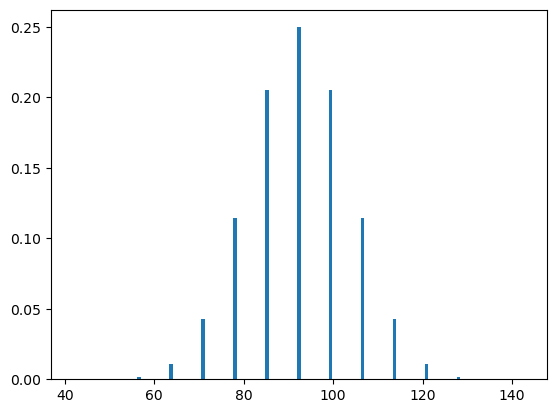

In [5]:
maturities = amd_calls.index.unique()
T0 = maturities[0]
C0 = amd_calls.loc[T0]
C0 = C0.reset_index(drop=True)
T1 = maturities[1]
C1 = amd_calls.loc[T1]
C1 = C1.reset_index(drop=True)
K = np.array(C1['Strike'])
ask = np.array(C1['Ask'])
bid = np.array(C1['Bid'])
mid = np.array(C1['Mid'])

a, b, n = S0-50, S0+50, 15 # Take odd n, such that X1[(n-1)/2] = S0
K1, K2 = a, b
X1 = np.linspace(a,b,n) # Discrete grid

t0 = date(2023, 4, 8)
t1 = maturities[0].to_pydatetime().date()
delta = t1 - t0
delta = delta.days
deltat = delta/252
P1_ = lambda s1: norm.pdf(s1, S0, calculate_sigma(C0,6/252,[S0],[1])*np.sqrt(6/252)) # Marginal distribution of S at t1
P1_disc = lambda x: P1_(x)/sum(P1_(X1))
xx = np.linspace(0,200,1000)
P1_disc_ = np.vectorize(P1_disc)
plt.bar(X1,P1_disc(X1))



u_list, h_list = np.zeros(n), np.zeros(n)
V0 = np.zeros(K.size)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)

# Test for S at t0
sigma0, beta = calculate_sigma0_beta(C0,6/252,[S0],[1])
print(sigma0)
print(beta)
print(sigma0*S0**beta) # Gives same value (82.267) -> OK

# Test for S at t1
#sigma0, beta = calculate_sigma0_beta(C1,7/365,X1,P1_disc(X1))
#print(sigma0)
#print(beta)
#print(sigma0*X1**beta)


# 
sigma = calculate_sigma(C1,7/365,X1,P1_disc(X1))
sigma_sqrtdt = sigma*np.sqrt(7/365)
print(m0(100,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1)))

In [6]:
def I_u_integrand(s2,theta,V,s1,K,sigma_sqrtdt,P_disc_X1):
    return np.exp(-np.sum(V*np.maximum(s2-K,0))+K.size*theta*(s2-s1))*m0(s2,s1,K,sigma_sqrtdt,P_disc_X1)

def I_u(theta,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2):
    Iu = np.zeros(X1.size)
    for i in range(X1.size): 
        Iu[i] = integrate.quad(I_u_integrand,K1,K2,args=(theta[i],V,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i]))[0]
    return Iu


def I_u_(theta,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2): 
    #assert(K1 <= K[0] and K2 >= K[-1])
    totI = 0

    for i in range(-1,K.size): 
        alpha = -sum(V[:i+1]) + K.size*theta
        gamma = sum(V[:i+1]*K[:i+1]) - K.size*(theta*X1)

        if (i == -1): 
            newPiece = np.exp(gamma) * I1(alpha,sigma_sqrtdt,X1,K1,K[0])
        if (i >= 0 and i < K.size-1):
            newPiece = np.exp(gamma) * I1(alpha,sigma_sqrtdt,X1,K[i],K[i+1]) # Piecewise integration
        if (i == K.size-1):
            newPiece = np.exp(gamma) * I1(alpha,sigma_sqrtdt,X1,K[-1],K2)
        
        newPiece *= P_disc_X1
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    return totI 

K = np.array(C1['Strike'])
sigma_sqrtdt = calculate_sigma(C1,6/252,X1,P1_disc(X1))*np.sqrt(6/252) #TODO: investigate why this one takes so long compared to I_h and I_Q
#print(I_u(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,K[0]))
#for i in range(0,numK-1):
    #print(I_u(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),K[i],K[i+1]))
#print(I_u(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),K[-1],110))

print("-----------")
#print(I_u_integrand(100,h_list,V0,X1,K,sigma_sqrtdt,P1_disc(X1)))
print(I_u_(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,110)) 
print(I_u(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,110))
# I attribute the differences on the boundaries due to inaccuracy in the integral aproximation?


# Test for S at t0
X0 = np.array([S0])
#P0 = lambda s: 1 if s == S0 else 0
P0_disc = np.array([1.])
sigma_sqrtdt0 = calculate_sigma(C0,6/252,X0,P0_disc)*np.sqrt(6/252)
print(I_u_(np.zeros(1),V0,X0,np.array(C0['Strike']),sigma_sqrtdt0,P0_disc,0,110))

-----------
[1.70506177e-05 2.17210555e-04 1.87068244e-03 1.08917472e-02
 4.28719633e-02 1.14084733e-01 2.05107555e-01 2.24946872e-01
 1.38288915e-01 6.07475760e-02 1.90325692e-02 3.84551429e-03
 4.94503932e-04 4.15904928e-05 2.33980064e-06]
[0.00000000e+00 2.17210555e-04 1.87068244e-03 1.08917472e-02
 4.28719633e-02 1.14084733e-01 2.05107555e-01 2.24946872e-01
 1.38290440e-01 6.09200995e-02 1.96580193e-02 4.27905413e-03
 6.07187616e-04 5.62886021e-05 3.44427226e-06]
[0.93948473]


In [7]:
def I_h_0_integrand(s2,theta,V,s1,K,sigma_sqrtdt,P_disc_X1):
    return np.exp(-np.sum(V*np.maximum(s2-K,0))+K.size*theta*(s2-s1))*m0(s2,s1,K,sigma_sqrtdt,P_disc_X1)*(s2-s1)

def I_h_0(theta,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2):
    Ih = np.zeros(X1.size)
    for i in range(X1.size): 
        Ih[i] = integrate.quad(I_h_0_integrand,K1,K2,args=(theta[i],V,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i]))[0]
    return Ih

def I_h_0_(theta,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2):
    print(f'theta = {theta}')
    #assert(K1 <= K[0] and K2 >= K[-1])
    totI = 0
    
    for i in range(-1,K.size): 
        alpha = -sum(V[:i+1]) + K.size*theta
        gamma = sum(V[:i+1]*K[:i+1]) - K.size*(theta*X1)
        #print(f'alpha = {alpha}')
        #print(f'sigma = {sigma}')
        
        if (i == -1): 
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma_sqrtdt,X1,K1,K[0])
        if (i >= 0 and i < K.size-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma_sqrtdt,X1,K[i],K[i+1]) # Piecewise integration
        if (i == K.size-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma_sqrtdt,X1,K[-1],K2)
        
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    print (f'i_h_0_ = {totI * P_disc_X1}')
    return totI * P_disc_X1



print(I_h_0_(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,110)) 
print(I_h_0(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,110))

# Test for S at t0
X0 = np.array([S0])
P0_disc = np.array([1.])
sigma_sqrtdt0 = calculate_sigma(C0,6/252,X0,P0_disc)*np.sqrt(6/252)
print(I_h_0_(np.zeros(1),V0,X0,np.array(C0['Strike']),sigma_sqrtdt0,P0_disc,0,110))




#TODO: implement multidimensional or not? -> yes: is Jacobian!
def I_h_0_grad_integrand(s2,theta,V,s1,K,sigma_sqrtdt,P_disc_X1): 
    # Is derivative wrt theta!
    return np.exp(-np.sum(V*np.maximum(s2-K,0))+K.size*theta*(s2-s1))*m0(s2,s1,K,sigma_sqrtdt,P_disc_X1)*(s2-s1)*(s2-s1)
    
def I_h_0_grad(theta,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2):
    Ih_grad = np.zeros((X1.size,V.size))
    if X1.size == 1: 
        Ih_grad = integrate.quad(I_h_0_grad_integrand,K1,K2,args=(theta,V,X1,K,sigma_sqrtdt,P_disc_X1))[0]
    else:
        for i in range(X1.size):
            Ih_grad[i] = integrate.quad(I_h_0_grad_integrand,K1,K2,args=(theta[i],V,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i]))[0]
    return Ih_grad

# implement multimensional?
def I_h_0_hessian_integrand(s2,theta,V,s1,K,sigma_sqrtdt,P_disc_X1):
    return np.exp(-np.sum(V*np.maximum(s2-K,0))+K.size*theta*(s2-s1))*m0(s2,s1,K,sigma_sqrtdt,P_disc_X1)*(s2-s1)*(s2-s1)*(s2-s1)

def I_h_0_hessian(theta,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2):
    return integrate.quad(I_h_0_hessian_integrand,K1,K2,args=(theta,V,X1,K,sigma_sqrtdt,P_disc_X1))[0]




theta = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
i_h_0_ = [ 0.00000000e+000  0.00000000e+000  0.00000000e+000  2.03907289e-106
  1.90704270e-025 -1.49538726e-014 -3.53924982e-003 -5.96700412e-001
 -1.73362701e+000 -1.70837080e+000 -8.59018779e-001 -2.26446495e-001
 -3.43681232e-002 -3.25915249e-003 -2.02067316e-004]
[ 0.00000000e+000  0.00000000e+000  0.00000000e+000  2.03907289e-106
  1.90704270e-025 -1.49538726e-014 -3.53924982e-003 -5.96700412e-001
 -1.73362701e+000 -1.70837080e+000 -8.59018779e-001 -2.26446495e-001
 -3.43681232e-002 -3.25915249e-003 -2.02067316e-004]
[ 0.00000000e+00 -2.12955994e-17  6.83589470e-17 -3.68628739e-18
 -2.55871713e-17 -1.50006791e-14 -3.53924982e-03 -5.96700412e-01
 -1.73364613e+00 -1.71322258e+00 -8.87247936e-01 -2.51975870e-01
 -4.21996621e-02 -4.41093926e-03 -2.97450491e-04]
theta = [0.]
i_h_0_ = [-1.36903454]
[-1.36903454]


In [8]:
def I_Q_integrand(s2,h_list,V,X1,K,Q,sigma_sqrtdt,P_disc_X1):
    return np.exp(-np.sum(V*np.maximum(s2-K,0))+K.size*h_list*(s2-X1))*m0(s2,X1,K,sigma_sqrtdt,P_disc_X1)*np.maximum(s2-Q,0)

def I_Q(h_list,V,X1,K,Q,sigma_sqrtdt,P_disc_X1,K1,K2):
    Iq = np.zeros(X1.size)
    for i in range(X1.size): 
        Iq[i] = integrate.quad(I_Q_integrand,K1,K2,args=(h_list[i],V,X1[i],K,Q,sigma_sqrtdt[i],P_disc_X1[i]))[0]
    return Iq

def I_Q_(h_list,V,X1,K,Q,sigma_sqrtdt,P_disc_X1,K1,K2):
    #assert(K1 <= K[0] and K2 >= K[-1])
    totI = 0

    for i in range(-1,K.size): 
        alpha = -sum(V[:i+1]) + K.size*h_list
        gamma = sum(V[:i+1]*K[:i+1]) - K.size*(h_list*X1)
        
        if (i == -1): 
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma_sqrtdt,X1,Q,K[0],Q) * (K[0] >= Q)
        if (i >= 0 and i < K.size-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma_sqrtdt,X1,max(Q,K[i]),K[i+1],Q) * (K[i+1] >= Q)
        if (i == K.size-1):
            if (Q <= K[-1]):
                newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma_sqrtdt,X1,K[-1],K2,Q) 
            else:
                newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma_sqrtdt,X1,Q,K2,Q) 
            
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece

    return totI * P_disc_X1


K = np.array(C1['Strike'])
print(I_Q_(h_list,V0,X1,np.array(C1['Strike']),K[0],sigma_sqrtdt,P1_disc(X1),0,110))
print(I_Q(h_list,V0,X1,np.array(C1['Strike']),K[0],sigma_sqrtdt,P1_disc(X1),0,110))

# Test for S at t0
X0 = np.array([S0])
P0_disc = np.array([1.])
sigma_sqrtdt0 = calculate_sigma(C0,6/252,X0,P0_disc)*np.sqrt(6/252)
print(I_Q_(np.zeros(1),V0,X0,K,K[0],sigma_sqrtdt0,P0_disc,0,110))

[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.28166971e-89
 3.33236064e-11 2.57928052e-02 8.73764702e-01 2.00477987e+00
 1.22548942e+00 4.20584020e-01 9.90000437e-02 1.62977383e-02
 1.86501828e-03 1.47532558e-04 8.04095260e-06]
[0.00000000e+000 0.00000000e+000 0.00000000e+000 2.37327708e-123
 3.56635944e-014 2.57928049e-002 8.73764702e-001 2.00477987e+000
 1.22550293e+000 4.21778481e-001 1.02253393e-001 1.81351308e-002
 2.29000320e-003 1.99670587e-004 1.18368669e-005]
[8.7053755]


In [9]:
def G1_(V,u_list,h_list,X1,C,omega,sigma_sqrtdt,P_disc_X1,K1,K2):
    K = np.array(C['Strike'])
    Iu = I_u_(h_list,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2)
    expectation = np.sum(Iu*np.exp(-u_list)*P_disc_X1)
    return np.sum(u_list*P_disc_X1) + np.sum(V*mid) + np.sum(f1(V,omega,C)) + expectation

    
def grad_G1_(V,u_list,h_list,X1,C,omega,sigma_sqrtdt,P_disc_X1,K1,K2):
    """
    Gradient of G_12 with respect to V_K_i
    """
    K = np.array(C['Strike'])
    mid = np.array(C['Mid'])
    grad = np.zeros(K.size)
    gf1 = grad_f1(V,omega,C)
    for i in range(K.size):
        Q = K[i]
        grad[i] = gf1[i] + mid[i] - np.sum(I_Q_(h_list,V,X1,K,Q,sigma_sqrtdt,P_disc_X1,K1,K2)*np.exp(-u_list)*P_disc_X1) # Q = K[i] #TODO: can this be sped up by providing Q as a vector?

    #print(f'Grad = {grad}')
    #print(f'Grad norm = {np.linalg.norm(grad)}')
    return grad

In [10]:
print(G1_(V0,u_list,h_list,X1,C1,omega_K,sigma_sqrtdt,P1_disc(X1),K1,K2))
print(grad_G1_(V0,u_list,h_list,X1,C1,omega_K,sigma_sqrtdt,P1_disc(X1),K1,K2))

0.17094441276833505
[ 7.82333138  7.00830152  6.16347127  5.36387455  4.6095562   3.87557356
  3.18700005  2.56892833  1.99647179  1.45976394  1.00895574  0.63421165
  0.32570495  0.08861316 -0.09188613 -0.21061867 -0.292416   -0.34211711
 -0.36456924 -0.36462806]


In [11]:
maturities = amd_calls.index.unique()
maturities

DatetimeIndex(['2023-04-06', '2023-04-14', '2023-04-21', '2023-04-28',
               '2023-05-05', '2023-05-12', '2023-05-19', '2023-05-26',
               '2023-06-16', '2023-07-21', '2023-09-15', '2023-10-20',
               '2024-01-19', '2024-06-21', '2025-01-17', '2025-12-19'],
              dtype='datetime64[ns]', name='Expiration Date', freq=None)

[82.26724939]
[0.01035145 0.01049248 0.01063171 0.01076901 0.01090427 0.01103736
 0.01116817 0.01129658 0.01142246 0.0115457  0.01166619 0.0117838
 0.01189844 0.01200999 0.01211834 0.01222339 0.01232504 0.01242318
 0.01251772 0.01260857 0.01269563 0.01277882 0.01285805 0.01293324
 0.01300432 0.01307122 0.01313386 0.01319218 0.01324613 0.01329564
 0.01334066 0.01338115 0.01341707 0.01344838 0.01347504 0.01349703
 0.01351432 0.0135269  0.01353475 0.01353787 0.01353625 0.01352989
 0.0135188  0.013503   0.01348249 0.0134573  0.01342746 0.01339299
 0.01335394 0.01331034 0.01326224 0.01320969 0.01315275 0.01309146
 0.0130259  0.01295614 0.01288223 0.01280427 0.01272232 0.01263647
 0.01254681 0.01245343 0.01235642 0.01225587 0.01215188 0.01204456
 0.01193401 0.01182033 0.01170364 0.01158405 0.01146167 0.01133661
 0.01120899 0.01107892 0.01094654 0.01081195 0.01067528 0.01053665
 0.01039617 0.01025399 0.0101102 ]


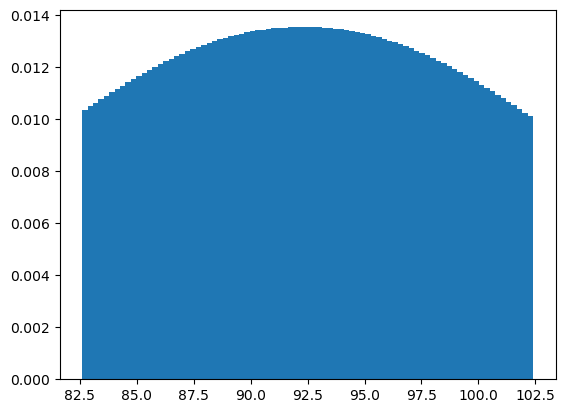

In [12]:
# Try to fit the multi-period case to the first period
T0 = maturities[0]
C0 = amd_calls.loc[T0]
C0 = C1.reset_index(drop=True)
T1 = maturities[1]
C1 = amd_calls.loc[T1]
C1 = C1.reset_index(drop=True)

r = 0.01 # TODO: figure out r
K = np.array(C1['Strike'])
ask = np.array(C1['Ask'])
bid = np.array(C1['Bid'])
mid = np.array(C1['Mid'])
#K1, K2, n = S0-30, S0+30, 81 # Take odd n, such that X1[(n-1)/2] = S0
K1, K2, n = K[0], K[-1], 81 # Take odd n, such that X1[(n-1)/2] = S0
X1 = np.linspace(K1,K2,n) # Discrete grid
u_list,h_list = np.zeros(n), np.zeros(n)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)
delta_t = 6/252
S0 = 92.3

#P1 = lambda s1: (s1 == S0)
#P1_disc = lambda x: P1(x)/sum(P1(X1))
#xx = np.linspace(0,200,1000)
#P1_disc_ = np.vectorize(P1_disc)
#plt.bar(X1,P1_disc_(X1))
#P_disc_X1 = np.zeros(n)
#P_disc_X1[int((n-1)/2)] = 1
#print(P1_disc_X1)
sigma_prev = calculate_sigma(C0,6/252,[S0],[1]) # sigma of previous marginal is used!!!
print(sigma_prev)
P1 = lambda s1: norm.pdf(s1, S0, sigma_prev*np.sqrt(delta_t)) # Marginal distribution of S at t1, 
P1_disc = lambda x: P1(x)/sum(P1(X1))
P1_disc_ = np.vectorize(P1_disc)
plt.bar(X1,P1_disc_(X1))
P_disc_X1 = P1_disc(X1)
print(P_disc_X1)

In [13]:
u0, h0, V0 = 0., 0., np.array([0.]*K.size)
V_prev = np.array([1] *K.size)
sigma_sqrtdt = calculate_sigma(C1,delta_t,X1,P_disc_X1)


#while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:
V_prev = V0
for i in range(n):
    #h0 = optimize.root_scalar(I_h_0_, args=(V0,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i],K1,K2), bracket=[-0.01,0.01], x0=0.00005, fprime = I_h_0_grad, fprime2 = I_h_0_hessian).root
    h0 = optimize.newton(I_h_0_, x0 = 0, args=(V0,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i],K1,K2), fprime = I_h_0_grad, fprime2 = I_h_0_hessian).x
    #h0 = optimize.minimize(I_h_0_,x0 = np.array([-0.01, 0.01]), args = (V0,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i],K1,K2), method='nelder-mead',options={'maxfev': 3000}).x # Slow convergence 
    print(f' h0 = {h0}')
    u0 = -np.log(P_disc_X1[i]/I_u_(h0,V0,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i],K1,K2))
    print(f' u0 = {u0}')



    #V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,sigma0,t1), method='BFGS', jac= grad_G1, hess=Hess_G1, hessp=None, bounds=None, constraints=(), tol=1e-2, callback=None, options=None).x
    #V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,delta_t,P1), method='Newton-CG', jac= grad_G1, hess=None, hessp=None, bounds=None, constraints=(), tol=1e-5, callback=None, options=None).x
    #print(f'V = {V}')
    
    #print(f'normdiff = {np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev)}')
    #print("----------")





theta = 0.0
i_h_0_ = 0.023190417793137887
theta = -0.18531408649624373
i_h_0_ = nan
theta = nan
i_h_0_ = nan


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_40432/944812879.py:7: RuntimeWarning: overflow encountered in exp
  return sigma*np.exp(alpha*s1) * ( 2*(np.exp(A*alpha*sigma-A*A/2) - np.exp(B*alpha*sigma-B*B/2)) + np.sqrt(2*np.pi)*alpha*sigma*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2))) )
/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_40432/944812879.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return sigma*np.exp(alpha*s1) * ( 2*(np.exp(A*alpha*sigma-A*A/2) - np.exp(B*alpha*sigma-B*B/2)) + np.sqrt(2*np.pi)*alpha*sigma*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2))) )
/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_40432/3892190818.py:56: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  und

theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan
theta = nan
i_h_0_ = nan


RuntimeError: Failed to converge after 50 iterations, value is nan.

In [ ]:
tt = np.linspace(-1e-1,1e-1,1000)
i = 0
Ih0 = lambda tt: I_h_0_(tt,V0,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i],K1,K2)
Ih0_ = np.vectorize(Ih0)
plt.plot(tt,Ih0_(tt))

In [ ]:
for T1 in maturities[1:2]:
    C1 = amd_calls.loc[T1]
    C1 = C1.reset_index(drop=True)
    
    r = 0.01 # TODO: figure out r
    ask = np.array(C1['Ask'])
    bid = np.array(C1['Bid'])
    mid = np.array(C1['Mid'])
    K = np.array(C1['Strike'])

    
    u_list = np.zeros(n)
    h_list = np.zeros(n)
    
    while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:
        for i in range(n): 
            s1 = X1[i]
            V_prev = V
            h0 = optimize.root_scalar(I_h_0_,args=(V,K,s1,50,120,delta_t,P1) ,bracket = [-0.02,0.02],x0=0.00005, fprime = I_h_0_grad, fprime2 = I_h_0_hessian).root
            h_list[i] = h0
            u0 = np.log(I_u_(h0,V,K,s1,50,120,delta_t,P1))
            u_list[i] = u[0]

        print(f'h_list = {h_list}')
        print(f'u_list = {u_list}')
        #V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,sigma0,t1), method='BFGS', jac= grad_G1, hess=Hess_G1, hessp=None, bounds=None, constraints=(), tol=1e-2, callback=None, options=None).x
        V = optimize.minimize(fun= G1_, x0=V, args=(u_list,h_list,K,omega_K,s1,delta_t,P1_,P1_disc(X1)), method='Newton-CG', jac= grad_G1_, hess=None, hessp=None, bounds=None, constraints=(), tol=1e-5, callback=None, options=None).x
        print(f'V = {V}')

        print(f'normdiff = {np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev)}')
        print("----------")

    
    
    
    # Compute next marginal probability (S at t2)
    P1 = lambda x:(1/(np.sqrt(2*math.pi)*1e-1)) * np.exp(-1/2*((x-S0)/1e-1)**2) * (x >= 0) # Approximation of Dirac delta around 
    P1_disc = lambda x: P1(x)/sum(P1(X1))
    #sum(P1_disc(X1)) = 1